# 03. TensorFlow ile Evrişimsel Sinir Ağları ve Bilgisayarla Görme

Şimdiye kadar TensorFlow'un temellerini ele aldık ve farklı problemlerde çalışmak için bir avuç model oluşturduk.

Şimdi spesifikleşeceğiz ve özel bir sinir ağı türü olan [evrişimli sinir ağlarının (CNN'ler)] (https://en.wikipedia.org/wiki/Convolutional_neural_network) bilgisayarla görme (görsel verilerdeki desenleri algılama) için nasıl kullanılabileceğini göreceğiz.

> 🔑 **Not:** Derin öğrenmede, farklı problemler için birçok farklı model mimarisi kullanılabilir. Örneğin, görüntü verileri ve/veya metin verileri üzerinde tahminler yapmak için bir konvolüsyonel sinir ağı kullanabilirsiniz. Ancak pratikte bazı mimariler genellikle diğerlerinden daha iyi çalışır.

Örneğin, şunları yapmak isteyebilirsiniz:
* Bir yemek resminin pizza 🍕 mı yoksa biftek 🥩 mi içerdiğini sınıflandırmak (bunu yapacağız)
* Bir görüntüde bir nesnenin görünüp görünmediğini tespit etme (örneğin, bir güvenlik kamerasından belirli bir araba geçti mi?)

Bu not defterinde, CNN'lerin nasıl oluşturulacağını ve kullanılacağını öğrenirken şimdiye kadar izlediğimiz TensorFlow modelleme iş akışını takip edeceğiz.

## Neleri ele alacağız

Spesifik olarak, TensorFlow ile takip üzerinden gideceğiz:

- Çalışmak için bir veri kümesi alma
- Konvolüsyonel sinir ağının mimarisi
- Hızlı bir uçtan uca örnek (üzerinde çalıştığımız şey)
- CNN'ler ile ikili görüntü sınıflandırması için modelleme adımları
  - Verilerle bütünleşmek
  - Modelleme için veri hazırlama
  - Bir CNN modeli oluşturma (bir taban çizgisinden başlayarak)
  - Bir model uydurma (verilerimizdeki örüntüleri bulmasını sağlama)
  - Bir modelin değerlendirilmesi
  - Bir modelin iyileştirilmesi
  - Eğitilmiş bir model ile tahmin yapma
- CNN'lerle çok sınıflı görüntü sınıflandırması için modelleme adımları
 - Yukarıdaki ile aynı (ancak bu sefer farklı bir veri kümesi ile)

## Bu not defterini nasıl kullanabilirsiniz

Açıklamaları ve kodu okuyabilirsiniz (bilerek hata veren hücreler dışında hepsi çalışmalıdır), ancak daha iyi bir seçenek var.

Tüm kodu kendiniz yazın.

Evet. Ciddiyim. Yeni bir not defteri oluşturun ve her satırı kendiniz yeniden yazın. Araştırın, kırıp kıramayacağınıza bakın, neden kırılıyor?

Metin açıklamalarını yazmak zorunda değilsiniz, ancak kodu kendiniz yazmak uygulamalı deneyim kazanmak için harika bir yoldur.

Hata yaparsanız endişelenmeyin, hepimiz hata yaparız. Daha iyi olmanın ve daha az hata yapmanın yolu **daha fazla kod yazmaktır**.




In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-05-15 16:45:59.177460


## Verileri alın

Konvolüsyonel sinir ağları görüntülerle çok iyi çalıştığından, onlar hakkında daha fazla bilgi edinmek için bir görüntü veri kümesiyle başlayacağız.

Birlikte çalışacağımız görüntüler, 101.000 (kategori başına 1000 görüntü) gerçek dünya yemek görüntüsünden oluşan 101 farklı kategoriden oluşan bir koleksiyon olan [Food-101 veri kümesinden] (https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) alınmıştır. 

Başlangıç olarak, kategorilerden yalnızca ikisini, pizza 🍕 ve biftek 🥩 kullanacağız ve ikili bir sınıflandırıcı oluşturacağız.

> 🔑 **Not:** Kullandığımız verileri hazırlamak için, görüntüleri farklı alt küme klasörlerine taşımak gibi ön işleme adımları yapılmıştır. Bu ön işleme adımlarını görmek için [the preprocessing notebook] (https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) adresine göz atın.

Biz `pizza_steak` alt küme .zip dosyasını indirip açacağız.

In [6]:
import zipfile

# Download zip file of pizza_steak images


# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

> 🔑 **Note:** If you're using Google Colab and your runtime disconnects, you may have to redownload the files. You can do this by rerunning the cell above.

## Verileri inceleyin (verilerle bütünleşin)

Herhangi bir makine öğrenimi projesinin başlangıcındaki çok önemli bir adım, verilerle bütünleşmektir. Bu genellikle birlikte çalıştığınız verileri anlamak için bolca görselleştirme ve klasör tarama anlamına gelir.

Bunu söyledikten sonra, yeni indirdiğimiz verileri inceleyelim.

Dosya yapısı, resimlerle çalışmak için kullanabileceğiniz tipik bir formatta olacak şekilde biçimlendirilmiştir.

Daha spesifik olarak:
* Eğitim veri setindeki tüm görüntüleri içeren bir `train` dizini ve her biri belirli bir sınıfın adını taşıyan ve o sınıfa ait görüntüleri içeren alt dizinler.
* Eğitim dizini ile aynı yapıya sahip bir `test` dizini.

```
Dosya yapısı örneği

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

İndirdiğimiz dizinlerin her birini inceleyelim.

Bunu yapmak için, liste anlamına gelen `ls` komutunu kullanabiliriz.

In [7]:
!ls pizza_steak

'ls' is not recognized as an internal or external command,
operable program or batch file.


We can see we've got a `train` and `test` folder.

Let's see what's inside one of them.

In [8]:
!ls pizza_steak/train/

'ls' is not recognized as an internal or external command,
operable program or batch file.


And how about insde the `steak` directory?

In [5]:
!ls pizza_steak/train/steak/

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

Woah, a whole bunch of images. But how many?

> 🛠 **Practice:** Try listing the same information for the `pizza` directory in the `test` folder.

In [9]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak\test'.
There are 0 directories and 250 images in 'pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'pizza_steak\test\steak'.
There are 2 directories and 0 images in 'pizza_steak\train'.
There are 0 directories and 750 images in 'pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'pizza_steak\train\steak'.


In [10]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

In [11]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


Okay, so we've got a collection of 750 training images and 250 testing images of pizza and steak.

Let's look at some.

> 🤔 **Note:** Whenever you're working with data, it's always good to visualize it as much as possible. Treat your first couple of steps of a project as becoming one with the data. **Visualize, visualize, visualize.**

In [12]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (344, 512, 3)


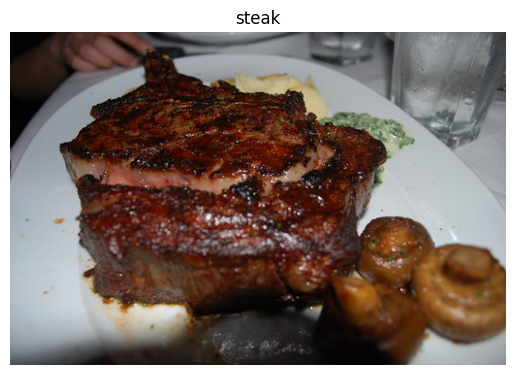

In [13]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

After going through a dozen or so images from the different classes, you can start to get an idea of what we're working with.

The entire Food101 dataset comprises of similar images from 101 different classes.

You might've noticed we've been printing the image shape alongside the plotted image.

This is because the way our computer sees the image is in the form of a big array (tensor).

In [14]:
# View the img (actually just a big array/tensor)
img

array([[[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 62,  61,  66],
        [ 61,  60,  65],
        [ 61,  60,  65]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 59,  58,  63],
        [ 58,  57,  62],
        [ 57,  56,  61]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 56,  55,  60],
        [ 54,  53,  58],
        [ 52,  51,  56]],

       ...,

       [[ 82,  85,  90],
        [ 82,  85,  90],
        [ 82,  85,  90],
        ...,
        [143, 146, 151],
        [141, 144, 149],
        [140, 143, 148]],

       [[ 77,  80,  85],
        [ 77,  80,  85],
        [ 77,  80,  85],
        ...,
        [142, 146, 149],
        [140, 144, 147],
        [138, 142, 145]],

       [[ 74,  77,  82],
        [ 74,  77,  82],
        [ 74,  77,  82],
        ...,
        [140, 144, 147],
        [138, 142, 145],
        [137, 141, 144]]

In [15]:
# View the image shape
img.shape # returns (width, height, colour channels)

(344, 512, 3)

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

> 🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [16]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        ...,
        [0.24313725, 0.23921569, 0.25882353],
        [0.23921569, 0.23529412, 0.25490196],
        [0.23921569, 0.23529412, 0.25490196]],

       [[0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        ...,
        [0.23137255, 0.22745098, 0.24705882],
        [0.22745098, 0.22352941, 0.24313725],
        [0.22352941, 0.21960784, 0.23921569]],

       [[0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        [0.01568627, 0.01568627, 0.01568627],
        ...,
        [0.21960784, 0.21568627, 0.23529412],
        [0.21176471, 0.20784314, 0.22745098],
        [0.20392157, 0.2       , 0.21960784]],

       ...,

       [[0.32156863, 0.33333333, 0.35294118],
        [0.32156863, 0.33333333, 0.35294118],
        [0.32156863, 0

## A (typical) architecture of a convolutional neural network

Convolutional neural networks are no different to other kinds of deep learning neural networks in the fact they can be created in many different ways. What you see below are some components you'd expect to find in a traditional CNN.


Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)
*A simple example of how you might stack together the above layers into a convolutional neural network. Note the convolutional and pooling layers can often be arranged and rearranged into many different formations.*

## Uçtan uca bir örnek

Verilerimizi kontrol ettik ve sınıf başına 750 eğitim görüntüsünün yanı sıra 250 test görüntüsü olduğunu ve bunların hepsinin çeşitli farklı şekillerde olduğunu gördük. 

Doğrudan derin uca atlamanın zamanı geldi.

Orijinal veri kümesi yazarlarının makalesini](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) okuduğumuzda, bir [Random Forest makine öğrenimi modeli](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) kullandıklarını ve farklı görüntülerde hangi farklı yiyeceklerin olduğunu tahmin etmede ortalama %50,76 doğruluk elde ettiklerini görüyoruz.

Şu andan itibaren, bu %50,76 bizim temel değerimiz olacak.

> 🔑 **Not:** Bir **baseline**, denemek ve geçmek istediğiniz bir puan veya değerlendirme ölçütüdür. Genellikle basit bir modelle başlar, bir taban çizgisi oluşturur ve modelin karmaşıklığını artırarak bunu geçmeye çalışırsınız. Makine öğrenimini öğrenmenin gerçekten eğlenceli bir yolu, yayınlanmış bir sonucu olan bir tür modelleme makalesi bulmak ve onu geçmeye çalışmaktır.

Aşağıdaki hücredeki kod, `pizza_steak` veri kümemizi yukarıda listelenen bileşenleri kullanarak bir evrişimli sinir ağı (CNN) ile modellemenin uçtan uca yolunu kopyalar.

Farkına varamayacağınız bir sürü şey olacaktır, ancak kodu kendiniz gözden geçirin ve ne yaptığını anlayıp anlayamayacağınıza bakın.

Not defterinin ilerleyen bölümlerinde her bir adımı gözden geçireceğiz.

Referans olarak, kullandığımız model [CNN açıklayıcı web sayfası](https://poloclub.github.io/cnn-explainer/)'nı besleyen bilgisayarla görme mimarisi TinyVGG'yi kopyalamaktadır.

> 📖 **Kaynak:** Aşağıda kullandığımız mimari, 2014 [ImageNet sınıflandırma yarışmasında] (http://image-net.org/) 2. olan bir evrişimli sinir ağı olan [VGG-16]'nın (https://arxiv.org/abs/1505.06798) küçültülmüş bir versiyonudur.

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 100s 2s/step - loss: 0.6136 - accuracy: 0.6693 - val_loss: 0.4375 - val_accuracy: 0.8020
Epoch 2/5
47/47 [==============================] - 87s 2s/step - loss: 0.4553 - accuracy: 0.8027 - val_loss: 0.3706 - val_accuracy: 0.8440
Epoch 3/5
47/47 [==============================] - 98s 2s/step - loss: 0.4332 - accuracy: 0.7947 - val_loss: 0.3481 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 90s 2s/step - loss: 0.3842 - accuracy: 0.8327 - val_loss: 0.3378 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 89s 2s/step - loss: 0.3229 - accuracy: 0.8693 - val_loss: 0.3298 - val_accuracy: 0.8540


> 🤔 **Not:** Yukarıdaki hücrenin çalışması epok başına ~12 saniyeden fazla sürüyorsa, bir GPU hızlandırıcı kullanmıyor olabilirsiniz. Bir Colab dizüstü bilgisayar kullanıyorsanız, Çalışma Zamanı -> Çalışma Zamanı Türünü Değiştir -> Donanım Hızlandırıcı'ya gidip "GPU" yu seçerek bir GPU hızlandırıcıya erişebilirsiniz. Bunu yaptıktan sonra, çalışma zamanı türünü değiştirmek Colab'ın sıfırlanmasına neden olacağından yukarıdaki hücrelerin tümünü yeniden çalıştırmanız gerekebilir.





Güzel! 5 epoktan sonra, modelimiz %50,76 doğrulukla temel skoru geçti (modelimiz eğitim setinde ~%85 ve test setinde ~%85 doğruluk elde etti).

Bununla birlikte, modelimiz Food101 veri kümesindeki 101 sınıfın tamamını değil, yalnızca ikili sınıflandırma problemini ele almıştır, bu nedenle bu ölçümleri doğrudan karşılaştıramayız. Bununla birlikte, şimdiye kadarki sonuçlar modelimizin bir şeyler öğrendiğini gösteriyor.

> 🛠 **Uygulama:** Yukarıdaki hücredeki ana kod bloklarının her birini adım adım inceleyin, sizce her biri ne yapıyor? Emin değilseniz sorun değil, bunu yakında gözden geçireceğiz. Bu arada, 10 dakikanızı inanılmaz [CNN açıklayıcı web sitesi] (https://poloclub.github.io/cnn-explainer/) üzerinde oynayarak geçirin. Web sayfasının üst kısmındaki katman isimleri hakkında ne fark ettiniz?


Zaten bir model oluşturduğumuza göre, şimdi de mimarisine bakalım.

In [18]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

Model_1`in katmanlarının adları ve [CNN explainer web sitesinin] (https://poloclub.github.io/cnn-explainer/) en üstündeki katman adları hakkında ne fark ettiniz?

Size küçük bir sır vereceğim: model demosu için kullandıkları mimariyi aynen kopyaladık.

Şuna bakın! **Doğada bulduğunuz modelleri kopyalamaya başladınız bile.

Şimdi burada tartışmadığımız birkaç yeni şey var, yani: 
* ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) sınıfı ve `rescale` parametresi
* [`flow_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) yöntemi
  * `batch_size` parametresi
  * `target_size` parametresi
* [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) katmanları (ve onlarla birlikte gelen parametreler)
* [`MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) katmanları (ve parametreleri).
* `fit()` fonksiyonundaki `steps_per_epoch` ve `validation_steps` parametreleri

Bunların her birine geçmeden önce, daha önce çalıştığımız bir modeli verilerimize uydurmaya çalışırsak ne olacağını görelim.


## Öncekiyle aynı modeli kullanarak

Sinir ağlarının birçok farklı probleme nasıl uyarlanabileceğini örneklemek için, daha önce oluşturduğumuz ikili bir sınıflandırma modelinin verilerimizle nasıl çalışabileceğini görelim.

> 🔑 **Not:** Önceki sınıflandırma not defterini incelemediyseniz, sorun değil, [TensorFlow Playground environment] (https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.001&regularizationRate=0&noise=0&networkShape=4,4&seed=0.75075&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) adresinden çoğaltılan noktaları ayırmak için kullanılan basit bir 4 katmanlı mimariyi getireceğiz.

İki şeyi değiştirmek dışında önceki modelimizdeki tüm aynı parametreleri kullanabiliriz:
* **Veriler** - artık noktalar yerine görüntülerle çalışıyoruz.
* **Girdi şekli** - sinir ağımıza birlikte çalıştığımız görüntülerin şeklini söylememiz gerekir.
  * Yaygın bir uygulama, görüntüleri tek bir boyutta yeniden şekillendirmektir. Bizim durumumuzda, görüntüleri `(224, 224, 3)` olarak yeniden boyutlandıracağız, yani 224 piksellik bir yükseklik ve genişlik ve kırmızı, yeşil, mavi renk kanalları için 3 derinlik.

In [19]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 14s 268ms/step - loss: 0.9620 - accuracy: 0.4993 - val_loss: 0.6318 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 11s 229ms/step - loss: 0.6390 - accuracy: 0.6327 - val_loss: 0.6335 - val_accuracy: 0.7620
Epoch 3/5
47/47 [==============================] - 11s 239ms/step - loss: 0.6171 - accuracy: 0.7153 - val_loss: 0.6111 - val_accuracy: 0.7600
Epoch 4/5
47/47 [==============================] - 14s 306ms/step - loss: 0.6050 - accuracy: 0.7373 - val_loss: 0.6011 - val_accuracy: 0.7640
Epoch 5/5
47/47 [==============================] - 15s 325ms/step - loss: 0.5916 - accuracy: 0.7387 - val_loss: 0.6014 - val_accuracy: 0.7720


Hmmm... modelimiz çalıştı ama bir şey öğrenmiş gibi görünmüyor. Eğitim ve test setlerinde yalnızca %50 doğruluğa ulaşıyor ki bu da ikili sınıflandırma probleminde tahmin etmek kadar iyi.

Mimariyi görelim.

In [20]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Vay canına. Burada en dikkat çekici şeylerden biri `model_1`e kıyasla `model_2`de çok daha fazla sayıda parametre olmasıdır.

Model_2`de 602.141 eğitilebilir parametre bulunurken, `model_1`de sadece 31.101 parametre bulunmaktadır. Bu farka rağmen, `model_1` hala `model_2`den çok daha iyi performans göstermektedir.

> 🔑 **Not:** Eğitilebilir parametreleri *bir modelin verilerden öğrenebileceği kalıplar* olarak düşünebilirsiniz. Sezgisel olarak, daha fazlasının daha iyi olduğunu düşünebilirsiniz. Ve bazı durumlarda öyledir. Ancak bu durumda, buradaki fark kullandığımız iki farklı model tarzındadır. Bir dizi yoğun katman birbirine bağlı bir dizi farklı öğrenilebilir parametreye ve dolayısıyla daha fazla sayıda olası öğrenilebilir desene sahipken, **bir evrişimli sinir ağı bir görüntüdeki en önemli desenleri ayırmaya ve öğrenmeye çalışır**. Dolayısıyla, konvolüsyonel sinir ağımızda daha az öğrenilebilir parametre olmasına rağmen, bunlar genellikle bir görüntüdeki farklı **özellikler** arasında ayrım yapmada daha yararlıdır.

Önceki modelimiz çalışmadığına göre, onu nasıl çalıştırabileceğimize dair bir fikriniz var mı?

Katman sayısını artırmaya ne dersiniz? 

Ve hatta belki de her katmandaki nöron sayısını artırsak?

Daha spesifik olarak, her yoğun katmandaki nöron sayısını (gizli birimler olarak da adlandırılır) 4'ten 100'e çıkaracağız ve fazladan bir katman ekleyeceğiz.

> 🔑 **Not:** Fazladan katman eklemek veya her katmandaki nöron sayısını artırmak genellikle modelinizin **karmaşıklığını** artırmak olarak adlandırılır.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Woah! Looks like our model is learning again. It got ~70% accuracy on the training set and ~70% accuracy on the validation set.

How does the architecute look?

In [ ]:
# Check out model_3 architecture
model_3.summary()

My gosh, the number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

We just went through a whirlwind of steps:

1. Become one with the data (visualize, visualize, visualize...)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

Let's step through each.

### 1. Import and become one with the data

Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You an also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

> 📖 **Resource:** To see how this data was processed into the file format we're using, see the [preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

If the visualization cell below doesn't work, make sure you've got the data by uncommenting the cell below.

In [ ]:
# import zipfile

# # Download zip file of pizza_steak images
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


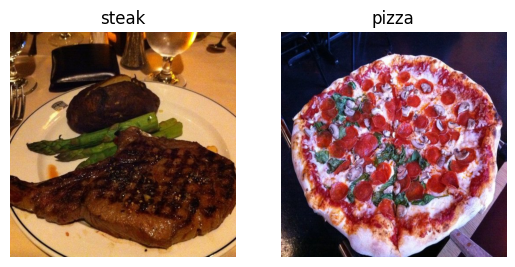

In [21]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data (prepare it for a model)

One of the most important steps for a machine learning project is creating a training and test set.

In our case, our data is already split into training and test sets. Another option here might be to create a validation set as well, but we'll leave that for now.

For an image classification project, it's standard to have your data seperated into `train` and `test` directories with subfolders in each for each class.

To start we define the training and test directory paths.

In [22]:
# Define training and test directory paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

A [batch size of 32 is good for your health](https://twitter.com/ylecun/status/989610208497360896?s=20). 

No seriously, there are many different batch sizes you could use but 32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for each of our datasets.


In [23]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

The `ImageDataGenerator` class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

You might've noticed the `rescale` parameter. This is one example of the transformations we're doing.

Remember from before how we imported an image and it's pixel values were between 0 and 255?

The `rescale` parameter, along with `1/255.` is like saying "divide all of the pixel values by 255". This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).

> 🔑 **Note:** For more transformation options such as data augmentation (we'll see this later), refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Now we've got a couple of ImageDataGenerator instances, we can load our images from their respective directories using the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [24]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Wonderful! Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:
* Due to how our directories are structured, the classes get inferred by the subdirectory names in `train_dir` and `test_dir`.
* The `target_size` parameter defines the input size of our images in `(height, width)` format.
* The `class_mode` value of `'binary'` defines our classification problem type. If we had more than two classes, we would use `'categorical'`.
* The `batch_size` defines how many images will be in each batch, we've used 32 which is the same as the default.

We can take a look at our batched images and labels by inspecting the `train_data` object.

In [25]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

Wonderful, it seems our images and labels are in batches of 32.

Let's see what the images look like.

In [26]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.1137255 , 0.11764707, 0.18823531],
          [0.1137255 , 0.11764707, 0.18823531],
          [0.10980393, 0.1137255 , 0.18431373],
          ...,
          [0.95294124, 0.9450981 , 0.9490197 ],
          [0.8235295 , 0.81568635, 0.8196079 ],
          [0.97647065, 0.9686275 , 0.9725491 ]],
 
         [[0.12156864, 0.1254902 , 0.19607845],
          [0.1254902 , 0.12941177, 0.20000002],
          [0.10196079, 0.10588236, 0.1764706 ],
          ...,
          [0.9333334 , 0.92549026, 0.9294118 ],
          [0.909804  , 0.90196085, 0.9058824 ],
          [0.9960785 , 0.98823535, 0.9921569 ]],
 
         [[0.09803922, 0.10196079, 0.17254902],
          [0.10588236, 0.10980393, 0.18039216],
          [0.1254902 , 0.13333334, 0.19215688],
          ...,
          [0.8000001 , 0.79215693, 0.7960785 ],
          [0.909804  , 0.90196085, 0.9058824 ],
          [1.        , 0.9960785 , 1.        ]],
 
         ...,
 
         [[0.09803922, 0.07843138, 0.09411766],
          [0.07843

Due to our `rescale` parameter, the images are now in `(224, 224, 3)` shape tensors with values between 0 and 1.

How about the labels?

In [ ]:
# View the first batch of labels
labels

Due to the `class_mode` parameter being `'binary'` our labels are either `0` (pizza) or `1` (steak).

Now that our data is ready, our model is going to try and figure out the patterns between the image tensors and the labels.

### 3. Create a model (start with a baseline)

You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on [ImageNet](https://www.image-net.org/) (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

> 🔑 **Note:** In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the [CNN explainer website](https://poloclub.github.io/cnn-explainer/) (`model_1` from above) and build a 3 layer convolutional neural network.

In [27]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [28]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

> 📖 **Resources:** For a great demonstration of these in action, be sure to spend some time going through the following:
  * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
  * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.
  * For a great explanation of padding, see this [Stack Overflow answer](https://stackoverflow.com/a/39371113/7900723).

Now our model is ready, let's compile it.

In [29]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

Since we're working on a binary classification problem (pizza vs. steak), the `loss` function we're using is `'binary_crossentropy'`, if it was mult-iclass, we might use something like `'categorical_crossentropy'`.

Adam with all the default settings is our optimizer and our evaluation metric is accuracy.

### 4. Fit a model

Our model is compiled, time to fit it.

You'll notice two new parameters here:
* `steps_per_epoch` - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of `train_data` (1500 images in batches of 32 = 1500/32 = ~47 steps)
* `validation_steps` - same as above, except for the `validation_data` parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [30]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [31]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
43/47 [==========================>...] - ETA: 8s - loss: 0.7842 - accuracy: 0.6676 

KeyboardInterrupt: 

### 5. Evaluate the model

Oh yeah! Looks like our model is learning something.

Let's check out its training curves.

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

Hmm, judging by our loss curves, it looks like our model is **overfitting** the training dataset.

> 🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

To further inspect our model's training performance, let's separate the accuracy and loss curves.

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [ ]:
# Check out our model's architecture
model_4.summary()

### 6. Adjust the model parameters

Fitting a machine learning model  comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

Not really...

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:
* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```

Let's built it. It'll have the same structure as `model_4` but with a [`MaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer after each convolutional layer.

In [ ]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_5 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

Woah, we've got another layer type we haven't seen before.

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the *most important* of those features. We'll see this an example of this in a moment.

In [ ]:
# Compile model (same as model_4)
model_5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Okay, it looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

Before we checkout its training curves, let's check out its architecture.

In [ ]:
# Check out the model architecture
model_5.summary()

Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each Conv2D layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

Time to check out the loss curves.

In [ ]:
# Plot loss curves of model_5 results
plot_loss_curves(history_5)

Nice! We can see the training curves get a lot closer to eachother. However, our the validation loss looks to start increasing towards the end and in turn potentially leading to overfitting.

Time to dig into our bag of tricks and try another method of overfitting prevention, data augmentation.

First, we'll see how it's done with code then we'll discuss what it's doing.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🤔 **Question:** What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

> 🔑 **Note:** Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [ ]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False) # Don't shuffle for demonstration purposes, usually a good thing to shuffle

# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Better than talk about data augmentation, how about we see it?

(remember our motto? visualize, visualize, visualize...)

In [ ]:
# Get data batch samples
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

In [ ]:
# Show original image and augmented image
random_number = random.randint(0, 32) # we're making batches of size 32, so we'll get a random instance
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

After going through a sample of original and augmented images, you can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

> 🤔 **Question:** Should I use data augmentation? And how much should I augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

Now we've got augmented data, let's try and refit a model on it and see how it affects training.

We'll use the same model as `model_5`.

In [ ]:
# Create the model (same as model_5)
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

> 🤔 **Question:** Why didn't our model get very good results on the training set to begin with?

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time. 

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

You may have also noticed each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

> 🔑 **Note:** One possible method to speed up dataset manipulation would be to look into [TensorFlow's parrallel reads and buffered prefecting options](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_6)

It seems our validation loss curve is heading in the right direction but it's a bit jumpy (the most ideal loss curve isn't too spiky but a smooth descent, however, a perfectly smooth loss curve is the equivalent of a fairytale).

Let's see what happens when we shuffle the augmented training data.

In [ ]:
# Import data and augment it from directories
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

In [ ]:
# Create the model (same as model_5 and model_6)
model_7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_7)

Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

Also, our loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

### 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1` or the TinyVGG architecture from [CNN explainer](https://poloclub.github.io/cnn-explainer/)).


In [ ]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_8 = model_8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

> 🔑 **Note:** You might've noticed we used some slightly different code to build `model_8` as compared to `model_1`. This is because of the imports we did before, such as `from tensorflow.keras.layers import Conv2D` reduce the amount of code we had to write. Although the code is different, the architectures are the same.

In [ ]:
# Check model_1 architecture (same as model_8)
model_1.summary()

In [ ]:
# Check model_8 architecture (same as model_1)
model_8.summary()

Now let's check out our TinyVGG model's performance.

In [ ]:
# Check out the TinyVGG model performance
plot_loss_curves(history_8)

In [ ]:
# How does this training curve look compared to the one above?
plot_loss_curves(history_1)

Hmm, our training curves are looking good, but our model's performance on the training and test sets didn't improve much compared to the previous model.

Taking another loook at the training curves, it looks like our model's performance might improve if we trained it a little longer (more epochs).

Perhaps that's something you like to try?

### Making a prediction with our trained model

What good is a trained model if you can't make predictions with it?

To really test it out, we'll upload a couple of our own images and see how the model goes.

First, let's remind ourselves of the classnames and view the image we're going to test on.

In [22]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


The first test image we're going to use is [a delicious steak](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg) I cooked the other day.

--2023-05-15 16:57:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.02s   

2023-05-15 16:57:06 (93.0 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



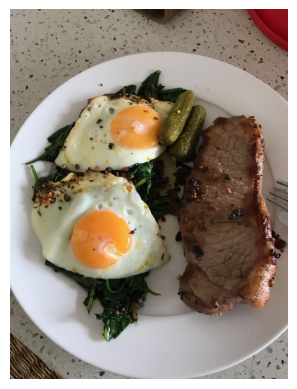

In [23]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [24]:
# Check the shape of our image
steak.shape

(4032, 3024, 3)

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

> 🔑 **Note:** For your model to make predictions on unseen data, for example, your own custom images, the custom image has to be in the same shape as your model has been trained on. In more general terms, to make predictions on custom data it has to be in the same form that your model has been trained on.

In [25]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

Now we've got a function to load our custom image, let's load it in.

In [26]:
# Load in and preprocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

Wonderful, our image is in tensor format, time to try it with our model!

In [27]:
# Make a prediction on our custom image (spoiler: this won't work)
model_1.predict(steak)

ValueError: ignored

There's one more problem...

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Remember how our model was trained in batches?

Well, the batch size becomes the first dimension.

So in reality, our model was trained on data in the shape of `(batch_size, 224, 224, 3)`.

We can fix this by adding an extra to our custom image tensor using [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims).

In [28]:
# Add an extra axis
print(f"Shape before new dimension: {steak.shape}")
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],

        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],

        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],

        ...,

        [[0.49313724, 0.42745098, 

Our custom image has a batch size of 1! Let's make a prediction on it.

In [29]:
# Make a prediction on custom image tensor
pred = model_1.predict(steak)
pred

1/1 [==============================] - 0s 182ms/step


array([[0.7519137]], dtype=float32)

Ahh, the predictions come out in **prediction probability** form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the **postive class** (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the **negative class** (class 0).

> 🔑 **Note:** The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

But saying positive and negative class doesn't make much sense when we're working with pizza 🍕 and steak 🥩...

So let's write a little function to convert predictions into their class names and then plot the target image.

In [30]:
# Remind ourselves of our class names
class_names

array(['pizza', 'steak'], dtype='<U5')

In [31]:
# We can index the predicted class by rounding the prediction probability
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'steak'

In [32]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [ ]:
# Test our model on a custom image
pred_and_plot(model_8, "03-steak.jpeg", class_names)

Nice! Our model got the prediction right.

The only downside of working with food is this is making me hungry.

Let's try one more image.

In [ ]:
# Download another test image and make a prediction on it
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(model_8, "03-pizza-dad.jpeg", class_names)

Two thumbs up! Woohoo!